# Check for the wave function eigenstates patterns
This is notebook for:
1. Checking patterns of wave function eigenstates (+-+-, ++++ etc.)
2. Checking the energy difference between highest and lowest energies in every group of 4 nearly degenerate states.


In [ ]:
# Libraries for numerical calculations, linear algebra and visualizations
import numpy as np
from scipy.linalg import eigh_tridiagonal
from numpy import linalg as LA
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # for loading bars (to see progress visually during long integration)
from scipy import sparse

# For stylized plots
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 80

## Solution 0. Finite Difference Method


In [ ]:
# Potential energy constants
V_2 = 0.09 * 0.043361254529175 # Convert from kcal/mol to eV/particle
V_4 = -2.10 * 0.043361254529175 # Convert from kcal/mol to eV/particle
V_6 = -0.29 * 0.043361254529175 # Convert from kcal/mol to eV/particle
# SE constants
h_bar = 6.626070150 * 10**-34 # Plancks constant, kg*m^2/s
M = 1.9944733 * 10**-26 # Mass of carbon, kg
# d = 0.417 * 10**-9
# d = 3 * 10**-9
d = 1.5  * 10**-9 # Diameter of benzene ring (not sure about this one), m
I = 1/2 * M * d ** 2 # Moment of inertia
KE_C = h_bar**2 / (2 * I) # Kinetic energy operator's constant, J
KE_C = KE_C * 6.241509 * 10**18 # Convert from J to eV
print("Kinetic energy coefficient: ", KE_C)

# Square well potential, for testing purposes
a = 1
V_min = -46 # eV
# def potential(phi):
#     if phi < a and phi > -a:
#         return V_min / KE_C
#     else:
#         return 0

# Biphenyl rotation potential
def potential(phi):
    return 1/2 * (V_2 * (1 - np.cos(2 * phi))
                + V_4 * (1 - np.cos(4 * phi))
                + V_6 * (1 - np.cos(6 * phi))) / KE_C

potential = np.vectorize(potential)

Kinetic energy coefficient:  6.106479662795717e-05


In [ ]:
# Define boundaries for eigenvalues of energies
from scipy.optimize import minimize
b_min = minimize(potential, 1).fun - 50 # Find minimum of the potential
b_max = 20

In [ ]:
# We are looking for wave function solution in this range of phi:
# phi_1, phi_2 = -3, 3 # For square well
phi_1, phi_2 = 0, 2 * np.pi # For Biphenyl

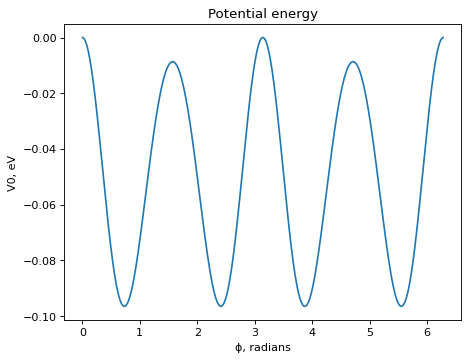

In [ ]:
x = np.arange(phi_1, phi_2, 0.01)
plt.plot(x, potential(x) * KE_C)
plt.title("Potential energy")
plt.xlabel(r'ϕ, radians')
plt.ylabel(r'V0, eV')
plt.show()

In [ ]:
# Define finite difference and amount of elements
N = 10000
phi = np.linspace(phi_1, phi_2, N)
dphi = np.diff(phi)[0]

In [ ]:
# Define and solve tridiagonal matrix eigenvalue problem
main_diag = 2 * np.ones(N) / dphi**2 + potential(phi)
second_diag = -np.ones(N - 1) / dphi**2
energies, wave_funcs = eigh_tridiagonal(main_diag,
                                        second_diag,
                                        select='v',
                                        select_range=(b_min, b_max))

In [ ]:
diags = [-np.ones(N - 1) / dphi**2,
         2 * np.ones(N) / dphi**2 + potential(phi),
         -np.ones(N - 1) / dphi**2]
offset = [-1, 0, 1]
H = sparse.diags(diags, offset).toarray()
H[0, N - 1] = -1 / dphi**2
H[N - 1, 0] = -1 / dphi**2

In [ ]:
# Define and solve matrix eigenvalue problem
# energies, wave_funcs = LA.eig(H, )

In [ ]:
wave_funcs = wave_funcs.T
# Sort wave functions by their energy eigenvalues
new_indexes = np.argsort(energies)
energies = energies[new_indexes]
wave_funcs = wave_funcs[new_indexes]
print(new_indexes[:5])

[0 1 2 3 4]


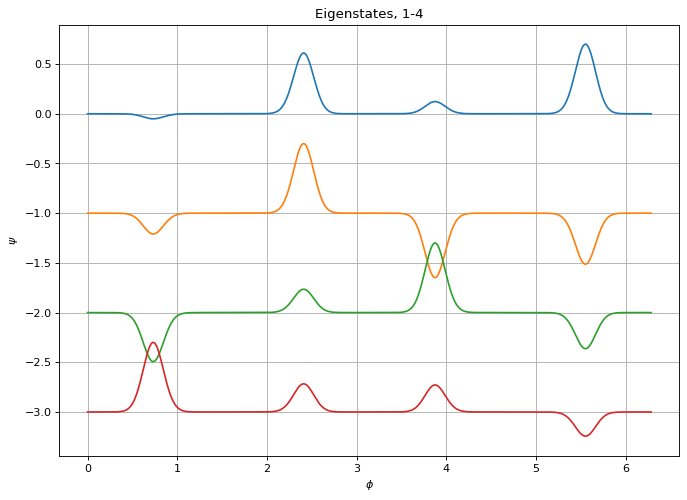

In [ ]:
plt.figure(figsize=(10,7))
for i in range(0, 4):
    plt.plot(phi, wave_funcs[i] / np.max(np.abs(wave_funcs[i])) * 0.7 - np.ones(N) * i)
plt.title('Eigenstates, 1-4')
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()

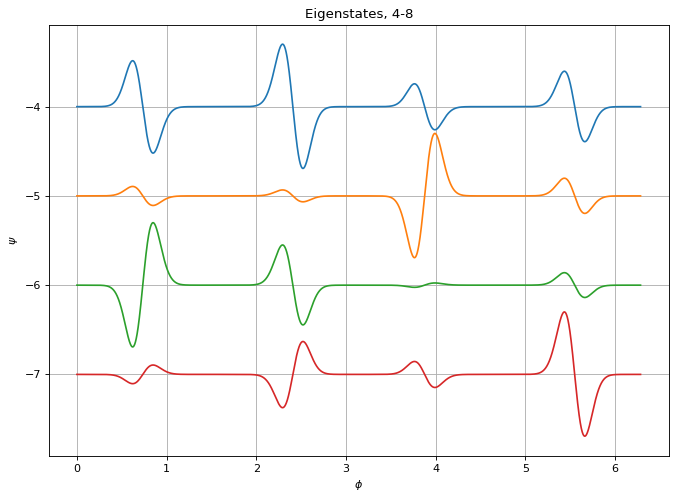

In [ ]:
plt.figure(figsize=(10,7))
for i in range(4, 8):
    plt.plot(phi, wave_funcs[i] / np.max(np.abs(wave_funcs[i])) * 0.7 - np.ones(N) * i)
plt.title('Eigenstates, 4-8')
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()

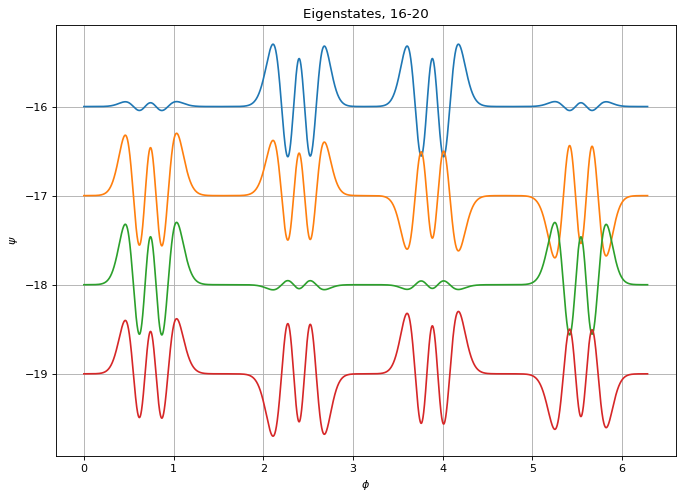

In [ ]:
plt.figure(figsize=(10,7))
minval = 16
maxval = 20
for i in range(minval, maxval):
    plt.plot(phi, wave_funcs[i] / np.max(np.abs(wave_funcs[i])) * 0.7 - np.ones(N) * i)
plt.title('Eigenstates, ' + str(minval) + '-' + str(maxval))
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()

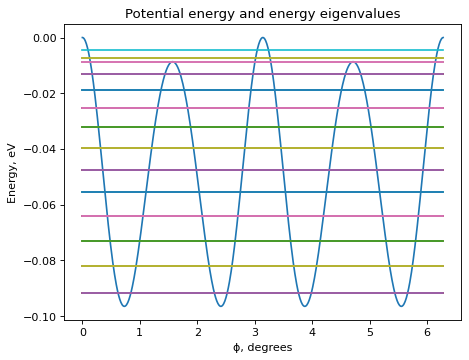

In [ ]:
n_energies_to_plot = 50
x = np.arange(phi_1, phi_2, 0.01)
plt.plot(x, potential(x) * KE_C)
for i in range(0, min(n_energies_to_plot, len(energies)) - 1):
    plt.plot(x, np.ones(len(x)) * (energies[i] * KE_C))
plt.title("Potential energy and energy eigenvalues")
plt.xlabel(r'ϕ, degrees')
plt.ylabel(r'Energy, eV')
plt.show()

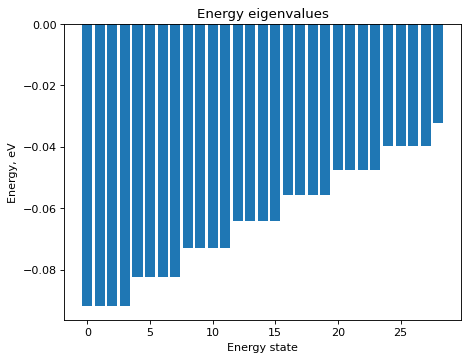

In [ ]:
n_energies_to_plot = 30
plt.bar(np.arange(0, min(n_energies_to_plot, len(energies)) - 1, 1),
        energies[:min(n_energies_to_plot, len(energies)) - 1] * KE_C)
plt.title("Energy eigenvalues")
plt.xlabel(r'Energy state')
plt.ylabel(r'Energy, eV')
plt.show()

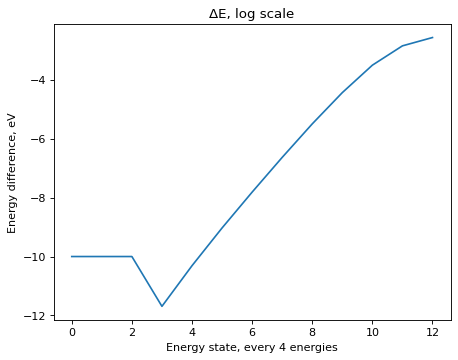

In [ ]:
# Energy splittings
delta_es = []
for i in range(0, len(energies)-4, 4):
    # If delta_e is zero, log10(0) will give error
    if energies[i+3] - energies[i] != 0:
        delta_es.append(energies[i+3] - energies[i])
    else:
        print()
        delta_es.append(10**-10 / KE_C)
delta_es = np.array(delta_es)

plt.plot(np.arange(0, len(delta_es), 1), np.log10(delta_es * KE_C))
plt.title("ΔE, log scale")
plt.xlabel(r'Energy state, every 4 energies')
plt.ylabel(r'Energy difference, eV')
plt.show()

## Solution 2. Rewriting wave function in Fourier basis with exponents
We rewrite our wave function in this form:
$$
\Psi(\phi)=\sum_{m=-\infty}^{\infty} c_m\Phi_m(\phi),
$$
where
$$
\Phi_m(\phi)=\frac{1}{\sqrt{2\pi}}e^{im\phi}
$$
As an approximation, we use m from -M to +M, where M is large.

In [ ]:
# Define amount of exponents for fourier basis
# Make bigger to get higher accuracy (runs slower)
M = 100

In [ ]:
H = np.zeros((M, M))
n_trapz = 4000

# Calculate Hamiltonian matrix
for m in tqdm(range(M)):
    for m_s in range(M):
        # Integration using trapezoidal rule
        def integrand(phi):
            return 1 / 2 / np.pi * np.cos(phi * (m_s - m)) * (
                   (m_s - M / 2) ** 2 * KE_C + potential(phi) * KE_C)
        x = np.linspace(phi_1, phi_2, n_trapz)
        H[m, m_s] = np.trapz(integrand(x), dx = (phi_2 - phi_1) / n_trapz)

  0%|          | 0/100 [00:00<?, ?it/s]

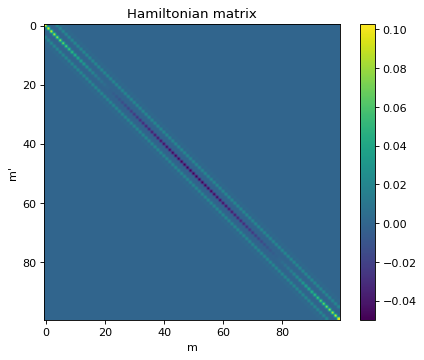

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(H)
ax.set_title("Hamiltonian matrix")
ax.set_xlabel(r'm')
ax.set_ylabel(r"m'")
cbar = ax.figure.colorbar(im, ax = ax)

In [ ]:
# Solve eigenvalue problem
energies, wf_coefficients = LA.eig(H)

In [ ]:
# Sort the energies and wave function coefficients, from smallest energy to biggest
new_indexes = np.argsort(energies)
energies = energies[new_indexes]
wf_coefficients = wf_coefficients.T[new_indexes]
print(new_indexes[:5])

[24 29 30 23 35]


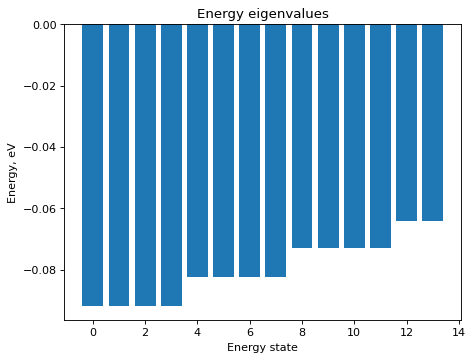

In [ ]:
n_energies_to_plot = 15
plt.bar(np.arange(0, min(n_energies_to_plot, len(energies)) - 1, 1),
        energies[:min(n_energies_to_plot, len(energies)) - 1])
plt.title("Energy eigenvalues")
plt.xlabel(r'Energy state')
plt.ylabel(r'Energy, eV')
plt.show()

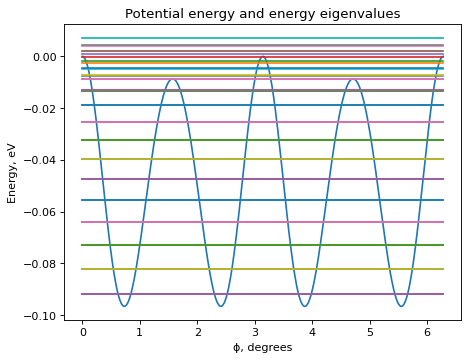

In [ ]:
n_energies_to_plot = 60
x = np.arange(phi_1, phi_2, 0.01)
plt.plot(x, potential(x) * KE_C)
for i in range(0, min(n_energies_to_plot, len(energies)) - 1):
    plt.plot(x, np.ones(len(x)) * (energies[i]))
plt.title("Potential energy and energy eigenvalues")
plt.xlabel(r'ϕ, degrees')
plt.ylabel(r'Energy, eV')
plt.show()

In [ ]:
# Define wave function as sum
def psi(phi, C):
    res = 0
    for m, coef in enumerate(C):
        res += coef * np.cos((m - M / 2) * phi) # cos is the real part of e^ix
    return res

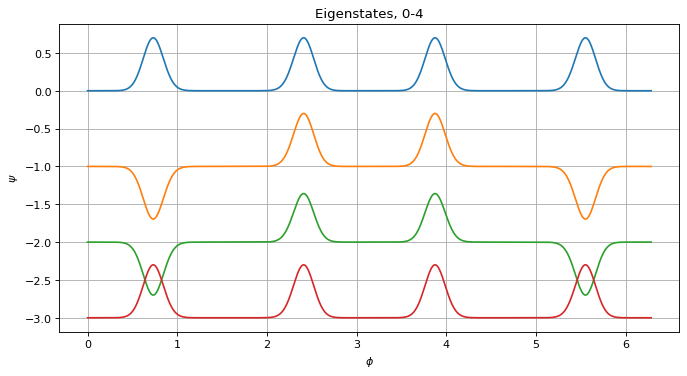

In [ ]:
# Plot wave functions
phi = np.linspace(phi_1, phi_2, N)
plt.figure(figsize=(10,5))
minval = 0
maxval = 4
for i in range(minval, maxval):
    plt.plot(phi, psi(phi, wf_coefficients[i]) /
             np.max(np.abs(psi(phi, wf_coefficients[i]))) * 0.7 - np.ones(N) * i)
plt.title('Eigenstates, ' + str(minval) + '-' + str(maxval))
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()

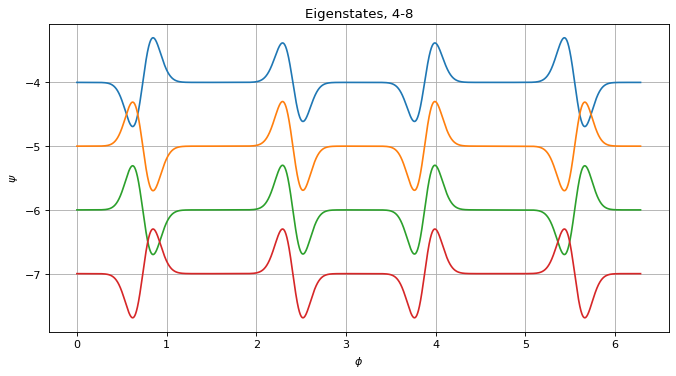

In [ ]:
# Plot wave functions
phi = np.linspace(phi_1, phi_2, N)
plt.figure(figsize=(10,5))
minval = 4
maxval = 8
for i in range(minval, maxval):
    plt.plot(phi, psi(phi, wf_coefficients[i]) /
             np.max(np.abs(psi(phi, wf_coefficients[i]))) * 0.7 - np.ones(N) * i)
plt.title('Eigenstates, ' + str(minval) + '-' + str(maxval))
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()

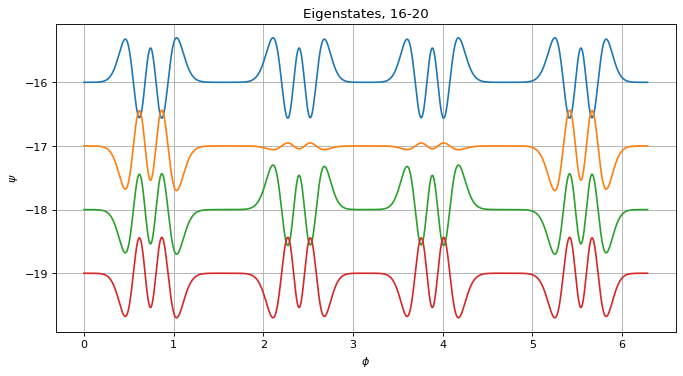

In [ ]:
# Plot wave functions
phi = np.linspace(phi_1, phi_2, N)
plt.figure(figsize=(10,5))
minval = 16
maxval = 20
for i in range(minval, maxval):
    plt.plot(phi, psi(phi, wf_coefficients[i]) /
             np.max(np.abs(psi(phi, wf_coefficients[i]))) * 0.7 - np.ones(N) * i)
plt.title('Eigenstates, ' + str(minval) + '-' + str(maxval))
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()

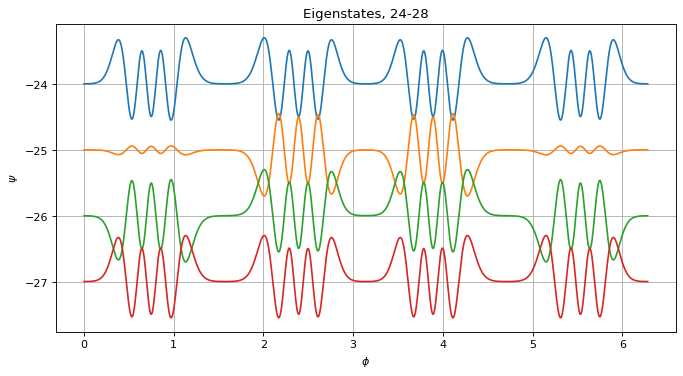

In [ ]:
# Plot wave functions
phi = np.linspace(phi_1, phi_2, N)
plt.figure(figsize=(10,5))
minval = 24
maxval = 28
for i in range(minval, maxval):
    plt.plot(phi, psi(phi, wf_coefficients[i]) /
             np.max(np.abs(psi(phi, wf_coefficients[i]))) * 0.7 - np.ones(N) * i)
plt.title('Eigenstates, ' + str(minval) + '-' + str(maxval))
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()

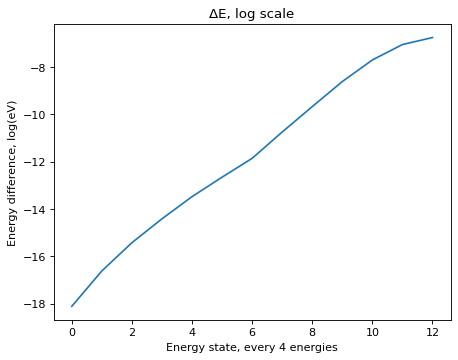

In [ ]:
# Energy splittings
delta_es = []
for i in range(0, len(energies)-48, 4):
    # If delta_e is zero, log10(0) will give error
    if energies[i+3] - energies[i] != 0:
        delta_es.append(np.abs(energies[i+3] - energies[i]))
    else:
        print('ΔE = 0 for i=', i)
        delta_es.append(10**-10 / KE_C)
delta_es = np.array(delta_es)

plt.plot(np.arange(0, len(delta_es), 1), np.log10(delta_es * KE_C))
plt.title("ΔE, log scale")
plt.xlabel(r'Energy state, every 4 energies')
plt.ylabel(r'Energy difference, log(eV)')
plt.show()